# Lecture 8
The **objective** of this lecture is to perform the exploratory analysis for a few of the datasets for the final project.  How do you do the exploration efficiently, knowing that there is a lot of data?  

### Justice40 Datasets

The web links to the datasets that are uploaded as part of the USDS data pipeline are posted below for direct access. Note that this is just a quick reference and the [Data Pipeline README](https://github.com/usds/justice40-tool/tree/main/data/data-pipeline#readme) has the comprehensive documentation on all these datasets.

> Note: These currently aren't updated on any specific cadence, so be aware of this if you know that the dataset you are using might change frequently.

- Census data, generated by the [Generate Census Github Action](https://github.com/usds/justice40-tool/blob/main/.github/workflows/generate-census.yml): <https://justice40-data.s3.us-east-1.amazonaws.com/data-sources/census.zip>
- Score data, generated by the [Generate Score Github Action](https://github.com/usds/justice40-tool/blob/main/.github/workflows/generate-score.yml): <https://justice40-data.s3.us-east-1.amazonaws.com/data-pipeline/data/score/csv/full/usa.csv>
- EJScreen: <https://justice40-data.s3.amazonaws.com/data-pipeline/data/dataset/ejscreen_2019/usa.csv>
- Census ACS 2019: <https://justice40-data.s3.amazonaws.com/data-pipeline/data/dataset/census_acs_2019/usa.csv>
- Housing and Transportation Index: <https://justice40-data.s3.amazonaws.com/data-pipeline/data/dataset/housing_and_transportation_index/usa.csv>
- HUD Housing: <https://justice40-data.s3.amazonaws.com/data-pipeline/data/dataset/hud_housing/usa.csv>

In [111]:
import pandas
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

The analysis of the environmental justice score requires a crash mini-course in the US census units - blocks, block groups, and tracts. The tool is based primarily on block groups, but the results are displayed at the tract level. [This is a useful reference](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#ti1969077500) to interpret the unique identifier `GEOID10` for the 2010 Census.  Note that this crash course will be useful for research into voting rights and environmental justice, which go hand-in-hand.

In [12]:
# Read in the ACS dataset directly (approx 450MB)
# try with and without setting `dtype` explicitly
df = pandas.read_csv(
    "https://justice40-data.s3.amazonaws.com/data-pipeline/data/dataset/census_acs_2019/usa.csv",
    dtype={"GEOID10": str}
)

### Example of how people are "hidden" in the data

The way that people are aggregated matters. [This article](https://ajph.aphapublications.org/doi/pdf/10.2105/AJPH.91.4.632), for example, cautions that proxy metrics for socioeconomic status that are created from aggregate statistics may create biased impacts.  This bias may be different, depending on the number of block groups in each census tract.  This is closely related to the [modifiable areal unit problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) - how are people aggregated?

In [17]:
# How many characters in the GEOID?  
# STATE+COUNTY+TRACT+BLOCK GROUP; Characters: 2+3+6+1=12
# This will be different if dtype is not explicitly set
set(df.GEOID10.str.len())

{12}

In [34]:
# The first 11 characters uniquely identify the census tract, the last is the block group.
df["tract"] = df.GEOID10.str[0:11]
df["state"] = df.GEOID10.str[0:2]
df["block_group"] = df.GEOID10.str[11:12]

df.head()

,GEOID10,Unemployed civilians (percent),Linguistic isolation (percent),Median household income in the past 12 months,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals < 200% Federal Poverty Line,tract,block_group,state
0,010399620002,0.077108,0.0,28250,0.099548,0.450226,0.579186,01039962000,2,01
1,010399618002,0.126214,0.0,22817,0.266884,0.443450,0.615948,01039961800,2,01
2,010399616004,0.133172,0.0,48088,0.134931,0.175284,0.345523,01039961600,4,01
3,010399616002,0.028249,0.0,64432,0.145435,0.216561,0.239915,01039961600,2,01
4,010399616001,0.063037,0.0,53081,0.213210,0.416570,0.468714,01039961600,1,01


The set of numbers for census tracts: {1, 2, 3, 4, 5, 6, 7, 8, 9}


(array([ 5911., 22126., 23836., 14629.,  5399.,  1637.,   389.,    74.]),
 array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 8 artists>)

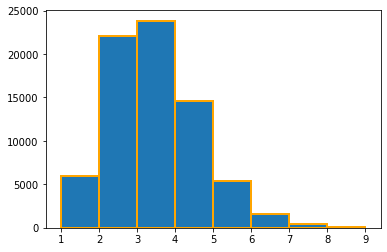

In [35]:
# How many block groups are in each Census tract?
# Note that, by naming convention alone, there can only be 10 block groups in each tract
tract_counts = df.groupby(["tract"])["tract"].count()
print("The set of numbers for census tracts: " + str(set(tract_counts)))

plt.hist(
    tract_counts, 
    bins=8, 
    edgecolor="orange",
    linewidth=2
)

The set of numbers for census tracts: {1, 2, 3, 4, 5, 6, 7, 8}


(array([16., 48., 35., 36., 22.,  8.,  1.,  1.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <BarContainer object of 8 artists>)

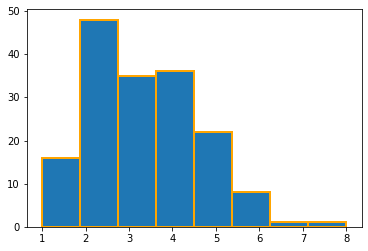

In [125]:
# What happens if we restrict our attention to States

# State codes: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696

# Name       FIPS
# Alaska     02
# California 06
# New York   36

state_df = df[df.state == "02"]

state_tract_counts = state_df.groupby(["tract"])["tract"].count()
print("The set of numbers for census tracts: " + str(set(state_tract_counts)))

plt.hist(
    state_tract_counts, 
    bins=8, 
    edgecolor="orange",
    linewidth=2
)

In [126]:
# Add this column in two ways, first create a data frame and merge
count_df = pandas.DataFrame(
    {
        "tract": state_tract_counts.index,
        "group_counts": state_tract_counts
    }
).reset_index(drop=True)


state_df.merge(count_df, on="tract")

,GEOID10,Unemployed civilians (percent),Linguistic isolation (percent),Median household income in the past 12 months,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals < 200% Federal Poverty Line,tract,block_group,state,count,group_counts
0,021800001003,0.243626,0.007519,46250,0.267303,0.454654,0.587112,02180000100,3,02,6,6
1,021800001006,0.353251,0.045584,43036,0.385209,0.555627,0.702894,02180000100,6,02,6,6
2,021800001002,0.270142,0.006410,34375,0.446771,0.568935,0.755672,02180000100,2,02,6,6
3,021800001001,0.169065,0.013333,33750,0.365885,0.535156,0.653646,02180000100,1,02,6,6
4,021800001005,0.279006,0.018265,42750,0.303761,0.528447,0.672131,02180000100,5,02,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
529,021850001002,0.202997,0.059387,57222,0.098202,0.258645,0.357538,02185000100,2,02,2,2
530,021220001001,0.191824,0.018182,38000,0.227360,0.335260,0.495183,02122000100,1,02,1,1
531,021980003001,0.000000,0.000000,64583,0.000000,0.000000,0.000000,02198000300,1,02,1,1
532,020160001001,0.031987,0.049107,59583,0.135484,0.234839,0.330323,02016000100,1,02,1,1


In [127]:
# second, directly add with the `.transform()` method
# (you can imagine that this is a common pattern)
state_df["count"] = state_df.groupby(["tract"])["tract"].transform("count")

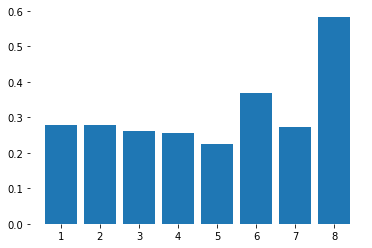

In [128]:
bar_data = state_df.groupby(["count"])["Percent of individuals < 200% Federal Poverty Line"].mean()

plt.bar(
    bar_data.index, 
    bar_data
)

plt.box(on=None)

This is what "getting lost in the data" actually means, averaging away important variation in trends; upward and downward, end up with a flat line

### Sampling

When you start working with larger datasets, like the energy dataset, that's like 40GB for the United States.  That would take like an hour just to download.  How can you start to examine the data?  Especially if you want to calculate percentiles quickly (and repeatedly)?

In [129]:
unemp = df["Unemployed civilians (percent)"]

# Find individual block group identifiers
# https://www.arcgis.com/apps/webappviewer/index.html?id=6ee43749c3544b3092ac36f2f2ce8f79

group_id = "060014221001" # where I live
x = float(df[df.GEOID10 == group_id]["Unemployed civilians (percent)"])
print(x)

# quantile
print(unemp.quantile(0.9))

# inverse quantile
stats.percentileofscore(unemp, x)

0.10256410256410256
0.13385826771653545


82.7470238230315

In order to get one statistic, you have to look at the entire population. Sometimes - though not here - it would take too long.

Where else?  

- Adjacency statistics
- Clustering statistics



In [134]:
df.sample(100)

,GEOID10,Unemployed civilians (percent),Linguistic isolation (percent),Median household income in the past 12 months,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals < 200% Federal Poverty Line,tract,block_group,state,count
47457,120310161003,0.030303,0.000000,46912,0.172073,0.208039,0.287024,12031016100,3,12,4
29708,060770051082,0.016204,0.167883,38387,0.287370,0.407879,0.462341,06077005108,2,06,3
112301,290718008006,0.228916,0.000000,47313,0.080477,0.329359,0.329359,29071800800,6,29,6
12965,060871225001,0.000000,0.153209,87625,0.187021,0.208993,0.229433,06087122500,1,06,4
120397,340030231002,0.019881,0.149351,50197,0.212101,0.396277,0.527261,34003023100,2,34,2
...,...,...,...,...,...,...,...,...,...,...,...
151668,390351407013,0.322493,0.000000,15299,0.663772,0.710918,0.710918,39035140701,3,39,3
202124,510594224012,0.037767,0.000000,109375,0.054012,0.076646,0.093107,51059422401,2,51,2
117762,320030032441,0.011331,0.012380,66488,0.073673,0.159196,0.207110,32003003244,1,32,2
199876,490351138031,0.000000,0.024775,64500,0.008681,0.197338,0.439236,49035113803,1,49,3


In [139]:
def find_unemp_perc(x, n=1000):
    _df = df.sample(n)
    unemp = _df["Unemployed civilians (percent)"]
    return stats.percentileofscore(unemp, x)

res = [find_unemp_perc(0.102564102) for b in range(1000)]

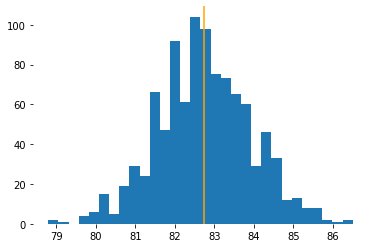

In [143]:
plt.hist(res, bins=30)

plt.axvline(
    stats.percentileofscore(unemp, x), 
    color="orange"
)

plt.box(on=None)